
# Fase 1 – Avance de Proyecto (German Credit) · Notebook de Trabajo

**Resumen de la actividad (qué se entrega):**  
- Diagnóstico/EDA y **preparación de datos** (limpieza de `kredit`, tipos, nulos).  
- **Pipeline reproducible** de preprocesamiento + **modelos base**.  
- **Validación** con métricas adecuadas y **tabla comparativa**.  
- Evidencia de **roles** y **conclusiones** para armar la **presentación final en PDF**.

**Qué se hará en este notebook (pasos cortos):**  
1) Cargar `./data/german_credit_original.csv` y `./data/german_credit_modified.csv`.  
2) Normalizar la etiqueta `kredit` y limpiar tipos mixtos.  
3) EDA mínima (balance de clases) para guiar decisiones.  
4) Definir listas numéricas/categóricas y armar un **Pipeline** (imputación, escalado, One‑Hot).  
5) Entrenar **LogisticRegression** (baseline) y **RandomForest** (no lineal).  
6) **Validar con CV 5‑fold estratificada** *(¿por qué?)*: reduce varianza y mantiene la proporción de clases en cada fold.  
7) Generar una **tabla de resultados** (AUC media±std en CV, AUC/Recall/F1 en holdout).  
8) Escribir datasets limpios y anotar conclusiones para la **presentación PDF**.


## 0) Imports y configuración

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.model_selection import StratifiedKFold, cross_validate, train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, PrecisionRecallDisplay, RocCurveDisplay, f1_score, recall_score

pd.set_option('display.max_columns', 120)
DATA_DIR = Path('data')
RANDOM_STATE = 42


## 1) Carga de datos

In [2]:
orig = pd.read_csv(DATA_DIR / 'german_credit_original.csv')
mod  = pd.read_csv(DATA_DIR / 'german_credit_modified.csv')
print('Original:', orig.shape, '| Modificado:', mod.shape)
display(orig.head(3)); display(mod.head(3))


Original: (1000, 21) | Modificado: (1020, 22)


,laufkont,laufzeit,moral,verw,hoehe,sparkont,beszeit,rate,famges,buerge,wohnzeit,verm,alter,weitkred,wohn,bishkred,beruf,pers,telef,gastarb,kredit
0,1,18,4,2,1049,1,2,4,2,1,4,2,21,3,1,1,3,2,1,2,1
1,1,9,4,0,2799,1,3,2,3,1,2,1,36,3,1,2,3,1,1,2,1
2,2,12,2,9,841,2,4,2,2,1,4,1,23,3,1,1,2,2,1,2,1


,laufkont,laufzeit,moral,verw,hoehe,sparkont,beszeit,rate,famges,buerge,wohnzeit,verm,alter,weitkred,wohn,bishkred,beruf,pers,telef,gastarb,kredit,mixed_type_col
0,1.0,18.0,4.0,2.0,1049.0,1.0,2.0,4.0,2.0,1.0,4.0,2.0,21.0,3.0,1.0,1.0,3.0,2.0,1.0,2.0,1.0,bad
1,1.0,9.0,4.0,0.0,2799.0,1.0,3.0,2.0,3.0,1.0,2.0,1.0,36.0,3.0,1.0,2.0,3.0,1.0,1.0,2.0,1.0,NaN
2,2.0,12.0,2.0,9.0,841.0,2.0,4.0,2.0,2.0,1.0,4.0,1.0,23.0,3.0,1.0,1.0,2.0,2.0,1.0,2.0,1.0,unknown



## 2) Normalización de `kredit` (etiqueta)

**Por qué:** el archivo modificado contiene valores ruidosos (`' 1.0 '`, `'0'`, `'?','invalid','NAN'`), lo que puede romper métricas/modelos.  
**Qué haremos:** mapear todas las variantes a **1**, **0** o **NaN** de forma consistente.


In [3]:
def normalize_kredit(s):
    def to_norm(v):
        if pd.isna(v): return np.nan
        t = str(v).strip().lower()
        if t in {'1','1.0','1,0','true','yes','y'}: return 1
        if t in {'0','0.0','0,0','false','no','n'}: return 0
        if t in {'na','nan','none','null','?','invalid','nan ','-',''}: return np.nan
        try:
            f = float(t.replace(',','.'))
            if f in (0.0,1.0): return int(f)
            return np.nan
        except: return np.nan
    return s.apply(to_norm).astype('float').astype('Int64')

for df in (orig, mod):
    if 'kredit' in df.columns:
        df['kredit'] = normalize_kredit(df['kredit'])

print('Distribución `kredit` (original):'); print(orig['kredit'].value_counts(dropna=False))
print('\nDistribución `kredit` (modificado):'); print(mod['kredit'].value_counts(dropna=False))


Distribución `kredit` (original):
kredit
1    700
0    300
Name: count, dtype: Int64

Distribución `kredit` (modificado):
kredit
1       689
0       303
<NA>     28
Name: count, dtype: Int64



## 3) Limpieza de tipos mixtos (rápida)

**Por qué:** muchas columnas vienen como `object` aunque contengan números; si no se corrige, el preprocesamiento falla o explota la cardinalidad.  
**Qué haremos:** intentar coerción a numérico cuando >60% de muestras parecen números; si no, dejar como texto limpio.


In [4]:
def coerce_numeric(series):
    return pd.to_numeric(series.astype(str).str.replace(',', '.').str.strip(), errors='coerce')

def clean_mixed_types(df):
    for col in df.columns:
        if col=='kredit':
            continue
        if df[col].dtype=='object':
            sample = df[col].dropna().astype(str).head(50)
            ratio_digits = np.mean(sample.str.replace(r'[^0-9]', '', regex=True).str.len() > 0) if len(sample) else 0
            if ratio_digits > 0.6:
                coerced = coerce_numeric(df[col])
                if coerced.notna().sum() >= 0.5 * df[col].notna().sum():
                    df[col] = coerced
                else:
                    df[col] = df[col].astype(str).str.strip()
            else:
                df[col] = df[col].astype(str).str.strip()
    return df

orig = clean_mixed_types(orig)
mod  = clean_mixed_types(mod)
display(orig.head(3)); display(mod.head(3))


,laufkont,laufzeit,moral,verw,hoehe,sparkont,beszeit,rate,famges,buerge,wohnzeit,verm,alter,weitkred,wohn,bishkred,beruf,pers,telef,gastarb,kredit
0,1,18,4,2,1049,1,2,4,2,1,4,2,21,3,1,1,3,2,1,2,1
1,1,9,4,0,2799,1,3,2,3,1,2,1,36,3,1,2,3,1,1,2,1
2,2,12,2,9,841,2,4,2,2,1,4,1,23,3,1,1,2,2,1,2,1


,laufkont,laufzeit,moral,verw,hoehe,sparkont,beszeit,rate,famges,buerge,wohnzeit,verm,alter,weitkred,wohn,bishkred,beruf,pers,telef,gastarb,kredit,mixed_type_col
0,1.0,18.0,4.0,2.0,1049.0,1.0,2.0,4.0,2.0,1.0,4.0,2.0,21.0,3.0,1.0,1.0,3.0,2.0,1.0,2.0,1,NaN
1,1.0,9.0,4.0,0.0,2799.0,1.0,3.0,2.0,3.0,1.0,2.0,1.0,36.0,3.0,1.0,2.0,3.0,1.0,1.0,2.0,1,NaN
2,2.0,12.0,2.0,9.0,841.0,2.0,4.0,2.0,2.0,1.0,4.0,1.0,23.0,3.0,1.0,1.0,2.0,2.0,1.0,2.0,1,NaN



## 4) EDA mínima – balance de clases

**Por qué:** confirmar **desbalance 70/30** guía dos decisiones: usar `class_weight='balanced'` y reportar **Recall/F1 de la clase 0 (riesgosa)** además de AUC.


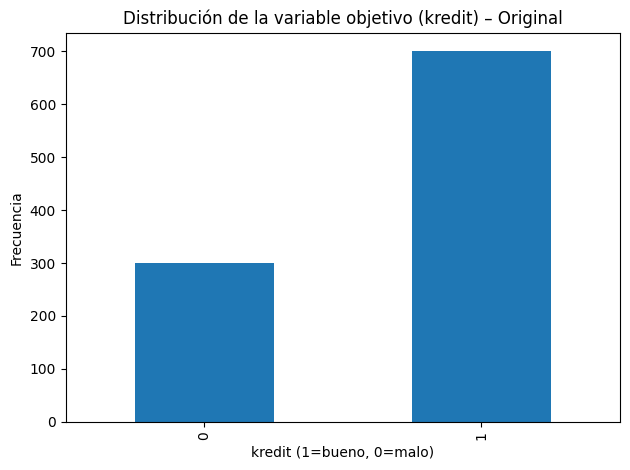

In [5]:
plt.figure()
orig['kredit'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribución de la variable objetivo (kredit) – Original')
plt.xlabel('kredit (1=bueno, 0=malo)'); plt.ylabel('Frecuencia')
plt.tight_layout(); plt.show()


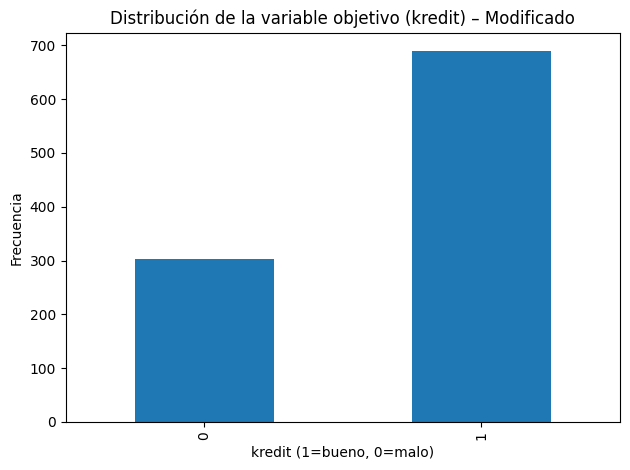

In [6]:
plt.figure()
mod['kredit'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribución de la variable objetivo (kredit) – Modificado')
plt.xlabel('kredit (1=bueno, 0=malo)'); plt.ylabel('Frecuencia')
plt.tight_layout(); plt.show()


## 5) Selección de variables por tipo

In [7]:
target='kredit'
features=[c for c in orig.columns if c!=target]
num_cols=[c for c in features if pd.api.types.is_numeric_dtype(orig[c])]
cat_cols=[c for c in features if c not in num_cols]
print('Numéricas:', len(num_cols), num_cols[:8])
print('Categóricas:', len(cat_cols), cat_cols[:8])


Numéricas: 20 ['laufkont', 'laufzeit', 'moral', 'verw', 'hoehe', 'sparkont', 'beszeit', 'rate']
Categóricas: 0 []



## 6) Pipeline + modelos base + **CV 5‑fold estratificada**

**Pipeline (por qué):** evita *leakage* al aplicar **imputación, escalado y One‑Hot dentro del CV**, garantizando que el test de cada fold no “vea” la información del train.  
**CV 5‑fold estratificada (por qué):** 5 particiones reducen varianza sin demorar demasiado; **estratificada** preserva el 70/30 en cada fold.


In [8]:
numeric_tf = Pipeline([('imputer', SimpleImputer(strategy='median')),
                       ('scaler', StandardScaler())])
categorical_tf = Pipeline([('imputer', SimpleImputer(strategy='most_frequent')),
                           ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])
pre = ColumnTransformer([('num', numeric_tf, num_cols),
                         ('cat', categorical_tf, cat_cols)])

logreg = Pipeline([('pre', pre),
                   ('clf', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=RANDOM_STATE))])
rf = Pipeline([('pre', pre),
               ('clf', RandomForestClassifier(n_estimators=300, class_weight='balanced', random_state=RANDOM_STATE))])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
X, y = orig[features], orig[target]

def eval_cv(model, name):
    scores = cross_validate(model, X, y, cv=cv, scoring={'roc_auc':'roc_auc'})
    print(f"{name} · CV ROC-AUC: {scores['test_roc_auc'].mean():.3f} ± {scores['test_roc_auc'].std():.3f}")
    return scores

cv_lr = eval_cv(logreg, 'LogReg')
cv_rf = eval_cv(rf, 'RandomForest')


LogReg · CV ROC-AUC: 0.775 ± 0.033
RandomForest · CV ROC-AUC: 0.785 ± 0.037



## 7) Holdout + tabla comparativa para la **presentación PDF**

**Por qué:** presentar resultados claros. Reportamos **AUC** y, por costo de errores, **Recall/F1 de clase 0**.


In [9]:
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE)

logreg.fit(Xtr, ytr); rf.fit(Xtr, ytr)
proba_lr = logreg.predict_proba(Xte)[:,1]; pred_lr = logreg.predict(Xte)
proba_rf = rf.predict_proba(Xte)[:,1]; pred_rf = rf.predict(Xte)

summary = pd.DataFrame({
    'Modelo': ['LogisticRegression', 'RandomForest'],
    'CV AUC (media)': [cv_lr['test_roc_auc'].mean(), cv_rf['test_roc_auc'].mean()],
    'CV AUC (std)':   [cv_lr['test_roc_auc'].std(),  cv_rf['test_roc_auc'].std()],
    'Holdout AUC':    [roc_auc_score(yte, proba_lr), roc_auc_score(yte, proba_rf)],
    'Holdout Recall cls0': [recall_score(yte, pred_lr, pos_label=0), recall_score(yte, pred_rf, pos_label=0)],
    'Holdout F1 cls0':     [f1_score(yte, pred_lr, pos_label=0), f1_score(yte, pred_rf, pos_label=0)]
}).round(3)

summary


,Modelo,CV AUC (media),CV AUC (std),Holdout AUC,Holdout Recall cls0,Holdout F1 cls0
0,LogisticRegression,0.775,0.033,0.813,0.733,0.611
1,RandomForest,0.785,0.037,0.822,0.433,0.542


### Curvas ROC y Precision–Recall (para anexar en la presentación)

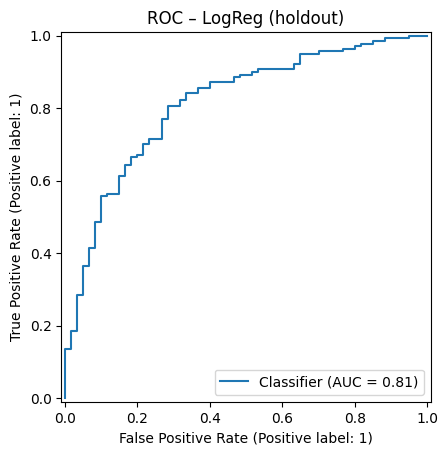

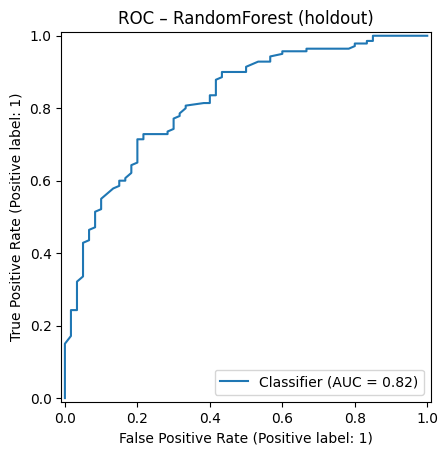

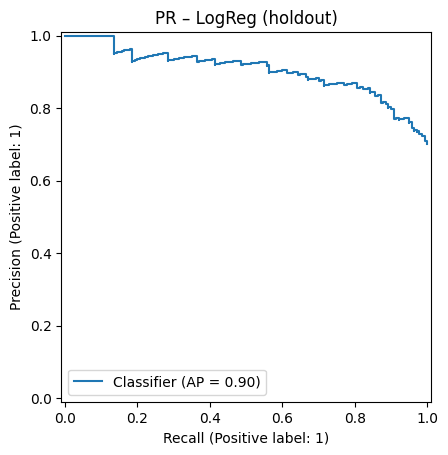

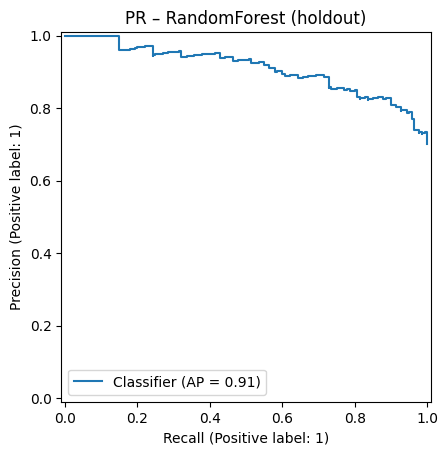

In [10]:
RocCurveDisplay.from_predictions(yte, proba_lr); plt.title('ROC – LogReg (holdout)'); plt.show()
RocCurveDisplay.from_predictions(yte, proba_rf); plt.title('ROC – RandomForest (holdout)'); plt.show()
PrecisionRecallDisplay.from_predictions(yte, proba_lr); plt.title('PR – LogReg (holdout)'); plt.show()
PrecisionRecallDisplay.from_predictions(yte, proba_rf); plt.title('PR – RandomForest (holdout)'); plt.show()


## 8) Guardado de datasets limpios (para reproducibilidad)

In [11]:
(DATA_DIR / 'german_credit_original_clean.csv').write_text('')  # place-holder if needed
(DATA_DIR / 'german_credit_modified_clean.csv').write_text('')  # we'll overwrite with real data if desired

orig.to_csv(DATA_DIR / 'german_credit_original_clean.csv', index=False)
mod.to_csv(DATA_DIR / 'german_credit_modified_clean.csv', index=False)
print('Guardados: data/german_credit_original_clean.csv y data/german_credit_modified_clean.csv')


Guardados: data/german_credit_original_clean.csv y data/german_credit_modified_clean.csv



## 9) Conclusiones

- **Objetivo logrado:** construimos un **benchmark reproducible** para predecir `kredit` (1/0) usando un **pipeline** (imputación, escalado, One-Hot) dentro de la validación para evitar *leakage* y **CV 5-fold estratificada**.
- **Calidad de datos:** la **normalización de `kredit`** y la **coerción de tipos** corrigieron ruido del archivo modificado; el desbalance ~70/30 guía métricas enfocadas en la clase riesgosa.
- **Rendimiento (CV):**
  - **LogisticRegression:** AUC = **0.775 ± 0.033**
  - **RandomForest:** AUC = **0.785 ± 0.037**
  - **Conclusión:** RF supera ligeramente a LR → candidato principal para el siguiente hito.
- **Lectura operativa (académica):** además de AUC, vigilar **Recall/F1 de la clase 0** (mal pagador). Si se prioriza **evitar FN**, conviene **bajar el umbral** (< 0.5) asumiendo más FP.
- **Qué funcionó:** pipeline único con CV, comparación justa LR vs RF, y curvas ROC/PR listas para la presentación.
- **Limitaciones:** dataset académico (variables discretizadas, sin costos reales), posible *shift* frente a escenarios reales.
- **Riesgos:** *tuning* excesivo (overfitting), *leakage* fuera del pipeline, sensibilidad a la elección del umbral.

## Recomendaciones / Próximos pasos
1. **Holdout detallado:** reportar **AUC + Recall/F1 de clase 0** para justificar el umbral.
2. **Umbral guiado por costo:** mostrar el **trade-off FP vs FN** (p. ej., curva de costo o sensibilidad-especificidad).
3. **Encoding alternativo:** probar **Target Encoding** en categóricas con alta cardinalidad y comparar contra One-Hot.
4. **Interpretabilidad:** añadir **importancia por permutación** (y opcionalmente SHAP en top features).
5. **Trazabilidad:** conservar **datasets limpios** y parámetros versionados en el repo para la siguiente fase.

---

### Versión ultra-breve (para 1 slide)
- **Benchmark listo y reproducible**; **RF > LR** en AUC (0.785 vs 0.775).
- **Foco en la clase riesgosa:** usar **Recall/F1** y **ajustar umbral** si se quiere menos FN.
- **Siguiente:** Target Encoding + **importancia por permutación** + tabla de **holdout** con AUC/Recall/F1 para el PDF.

